In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# ===================================================================
# 1. 라이브러리 임포트 및 설정
# ===================================================================
import numpy as np
import h5py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import sys
import warnings

# 불필요한 경고 메시지 숨기기
warnings.filterwarnings('ignore', category=FutureWarning)
tf.get_logger().setLevel('ERROR')
print("라이브러리 임포트 완료!")

라이브러리 임포트 완료!


In [5]:
# ===================================================================
# 2. 전처리 함수 정의
# ===================================================================
def extract_signal_data(mat_data, refs_dataset, target_length=1250):
    """신호 데이터를 추출하고 길이를 통일하는 함수"""
    segments = []
    for ref in refs_dataset[0, :]:
        segment_data = mat_data[ref][:].flatten()
        if len(segment_data) > target_length:
            segment_data = segment_data[:target_length]
        elif len(segment_data) < target_length:
            padding = np.zeros(target_length - len(segment_data))
            segment_data = np.concatenate([segment_data, padding])
        segments.append(segment_data)
    return np.array(segments, dtype=np.float32)

def extract_label_data(mat_data, refs_dataset):
    """레이블 데이터를 추출하는 함수"""
    labels = []
    for ref in refs_dataset[0, :]:
        value = mat_data[ref][0, 0]
        labels.append(value)
    return np.array(labels, dtype=np.float32)

def create_cnn_model(input_shape):
    model = Sequential([
        # 1st Conv Block: 노이즈 평활화 및 특징 추출 (커널 25 유지)
        Conv1D(filters=32, kernel_size=25, activation='relu', padding='same',
               kernel_regularizer=l2(0.0005), input_shape=input_shape),
        Dropout(0.2),

        # 2nd Conv Block: 깊은 특징 추출
        Conv1D(filters=64, kernel_size=15, activation='relu', padding='same',
               kernel_regularizer=l2(0.0005)),
        Dropout(0.2),

        # 3rd Conv Block: 추가 특징 추출
        Conv1D(filters=128, kernel_size=7, activation='relu', padding='same',
               kernel_regularizer=l2(0.0005)),
        Dropout(0.3),

        # Global Average Pooling: 시간 축을 따라 평균을 내어 특징 벡터로 변환
        GlobalAveragePooling1D(),

        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(2, activation='linear') # SBP, DBP 2개 예측
    ])

    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])
    return model


In [11]:
# ===================================================================
# 3. 데이터 로드 및 전처리 (PPG Only)
# ===================================================================
file_path = '/content/drive/MyDrive/p098347.mat'
TARGET_LENGTH = 1250 # 10초, 125Hz 가정 (PulseDB 세그먼트 표준)
X_signals, y_bp = None, None

try:
    with h5py.File(file_path, 'r') as mat_data:
        print(f"'{file_path}' 파일 로딩 성공 (HDF5 형식)!")

        # PPG 신호와 혈압 레이블 추출
        ppg_segments = extract_signal_data(mat_data, mat_data['Subj_Wins']['PPG_F'], TARGET_LENGTH)
        sbp_labels = extract_label_data(mat_data, mat_data['Subj_Wins']['SegSBP'])
        dbp_labels = extract_label_data(mat_data, mat_data['Subj_Wins']['SegDBP'])

    print(f"\n데이터 추출 및 변환 최종 성공! (총 {len(ppg_segments)} 세그먼트)")

    # 2000 세그먼트 제한
    MAX_SEGMENTS = 2000
    num_segments_to_use = min(len(ppg_segments), MAX_SEGMENTS)

    ppg_segments = ppg_segments[:num_segments_to_use]
    sbp_labels = sbp_labels[:num_segments_to_use]
    dbp_labels = dbp_labels[:num_segments_to_use]

    # PPG 신호만으로 입력 데이터 구성
    X_signals = np.expand_dims(ppg_segments, axis=-1)
    y_bp = np.stack([sbp_labels, dbp_labels], axis=-1)

    print(f"최종 사용 세그먼트 개수: {num_segments_to_use}개")
    print(f"입력 데이터 X shape: {X_signals.shape}, 타겟 데이터 y shape: {y_bp.shape}")

except FileNotFoundError:
    print(f"\n오류: '{file_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
    sys.exit(1)
except Exception as e:
    print(f"\n데이터 처리 중 얘기치 못한 오류가 발생했습니다: {e}")
    sys.exit(1)


'/content/drive/MyDrive/p098347.mat' 파일 로딩 성공 (HDF5 형식)!

데이터 추출 및 변환 최종 성공! (총 4158 세그먼트)
최종 사용 세그먼트 개수: 2000개
입력 데이터 X shape: (2000, 1250, 1), 타겟 데이터 y shape: (2000, 2)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54792 (\N{HANGUL SYLLABLE HYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50517 (\N{HANGUL SYLLABLE AB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

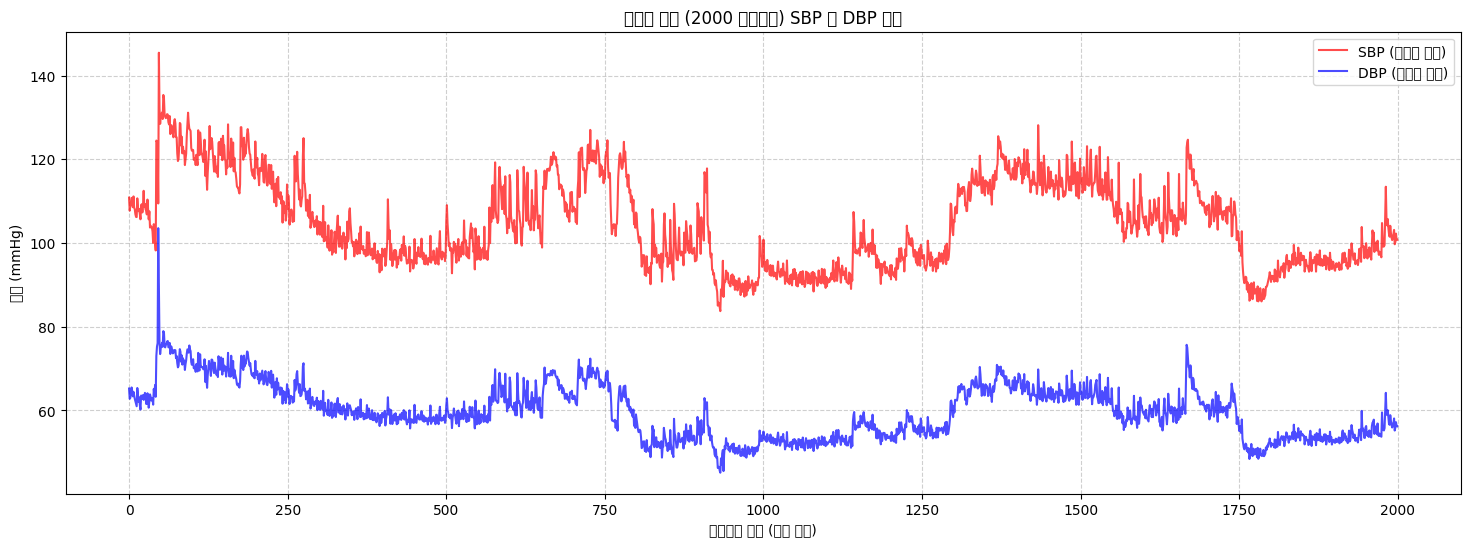

In [12]:
# ===================================================================
# 4. 전체 혈압 변동 그래프 시각화 (요구사항 2)
# ===================================================================
plt.figure(figsize=(18, 6))
plt.plot(sbp_labels, label='SBP (수축기 혈압)', color='red', alpha=0.7)
plt.plot(dbp_labels, label='DBP (이완기 혈압)', color='blue', alpha=0.7)
plt.title(f'환자의 전체 ({num_segments_to_use} 세그먼트) SBP 및 DBP 변동') # 환자 번호 제거
plt.xlabel('세그먼트 번호 (시간 순서)')
plt.ylabel('혈압 (mmHg)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [15]:
# ===================================================================
# 5. K-Fold 교차 검증 및 모델 학습/평가
# ===================================================================
N_SPLITS = 5
SEGMENTS_PER_FOLD = 400
TRAIN_SIZE = 320    # 훈련 세그먼트
VAL_SIZE = 40       # 검증 세그먼트 (Early Stopping용)
TEST_SIZE = 40      # 테스트 세그먼트 (최종 평가용)
TOTAL_SEGMENTS = X_signals.shape[0]

# 데이터 부족 시 오류 처리 (2000개 미만일 경우)
if TOTAL_SEGMENTS < N_SPLITS * SEGMENTS_PER_FOLD:
    print(f"\n경고: 총 {TOTAL_SEGMENTS} 세그먼트로, 요청된 {N_SPLITS}-Fold (2000개)를 구성하기에 데이터가 부족합니다.")
    N_SPLITS = TOTAL_SEGMENTS // SEGMENTS_PER_FOLD
    if N_SPLITS == 0:
        print("\n오류: 1개 Fold(400 세그먼트) 구성에 필요한 데이터가 부족합니다. 학습 중단.")
        sys.exit(1)
    print(f"데이터에 맞춰 {N_SPLITS}-Fold로 교차 검증을 실행합니다.")

sbp_maes, dbp_maes = [], []
sbp_rmses, dbp_rmses = [], []

for k in range(N_SPLITS):
    print("\n" + "="*60)
    print(f" FOLD {k+1}/{N_SPLITS} 시작 (세그먼트 {k*SEGMENTS_PER_FOLD+1} ~ {(k+1)*SEGMENTS_PER_FOLD}) ".center(60, "="))
    print("="*60)

    # 시간 연속적 분할 (320 / 40 / 40)
    fold_start_idx = k * SEGMENTS_PER_FOLD
    train_indices = range(fold_start_idx, fold_start_idx + TRAIN_SIZE)
    val_indices = range(fold_start_idx + TRAIN_SIZE, fold_start_idx + TRAIN_SIZE + VAL_SIZE)
    test_indices = range(fold_start_idx + TRAIN_SIZE + VAL_SIZE, fold_start_idx + TRAIN_SIZE + VAL_SIZE + TEST_SIZE)

    X_train_raw, y_train = X_signals[train_indices], y_bp[train_indices]
    X_val_raw, y_val = X_signals[val_indices], y_bp[val_indices]
    X_test_raw, y_test = X_signals[test_indices], y_bp[test_indices]

    print(f"Fold {k+1} 분할: 훈련 {len(X_train_raw)} / 검증 {len(X_val_raw)} / 테스트 {len(X_test_raw)} 개")

    # 데이터 스케일링: 훈련 데이터에만 fit (Data Leakage 방지)
    scaler = StandardScaler()
    n_samples_train, n_timesteps, n_features = X_train_raw.shape

    # 3D -> 2D 변환 후 스케일링 적용
    X_train_reshaped = X_train_raw.reshape(-1, n_features)
    scaler.fit(X_train_reshaped)

    X_train_scaled = scaler.transform(X_train_reshaped).reshape(n_samples_train, n_timesteps, n_features)
    X_val_scaled = scaler.transform(X_val_raw.reshape(-1, n_features)).reshape(len(X_val_raw), n_timesteps, n_features)
    X_test_scaled = scaler.transform(X_test_raw.reshape(-1, n_features)).reshape(len(X_test_raw), n_timesteps, n_features)

    print("데이터 스케일링 완료.")

    # 모델 생성 및 학습
    input_shape = (X_signals.shape[1], X_signals.shape[2])
    model = create_cnn_model(input_shape)

    if k == 0:
        print("\n--- 모델 구조 (순수 CNN) ---")
        model.summary()

    print("\n모델 학습 시작...")

    # EarlyStopping: 검증 세트 손실을 모니터링 (patience=20으로 증가)
    es_callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # ReduceLROnPlateau: 학습 정체 시 학습률 감소
    lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)

    history = model.fit(
        X_train_scaled, y_train, epochs=200, batch_size=32, verbose=0, # Epochs 증가
        validation_data=(X_val_scaled, y_val),
        callbacks=[es_callback, lr_callback] # 두 콜백 모두 적용
    )

    best_epoch = np.argmin(history.history['val_loss']) + 1
    print(f"Fold {k+1}: 모델 학습 완료 (Best epoch: {best_epoch})")

    # 테스트 세트 예측 및 평가
    predictions = model.predict(X_test_scaled, verbose=0)

    # MAE 및 RMSE 계산
    fold_sbp_mae = mean_absolute_error(y_test[:, 0], predictions[:, 0])
    fold_dbp_mae = mean_absolute_error(y_test[:, 1], predictions[:, 1])
    fold_sbp_rmse = np.sqrt(mean_squared_error(y_test[:, 0], predictions[:, 0]))
    fold_dbp_rmse = np.sqrt(mean_squared_error(y_test[:, 1], predictions[:, 1]))

    sbp_maes.append(fold_sbp_mae)
    dbp_maes.append(fold_dbp_mae)
    sbp_rmses.append(fold_sbp_rmse)
    dbp_rmses.append(fold_dbp_rmse)

    print(f"\n--- FOLD {k+1} 결과 ---")
    print(f"SBP MAE: {fold_sbp_mae:.4f} | RMSE: {fold_sbp_rmse:.4f}")
    print(f"DBP MAE: {fold_dbp_mae:.4f} | RMSE: {fold_dbp_rmse:.4f}")



================ FOLD 1/5 시작 (세그먼트 1 ~ 400) ================
Fold 1 분할: 훈련 320 / 검증 40 / 테스트 40 개
데이터 스케일링 완료.

--- 모델 구조 (순수 CNN) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)              │ (None, 1250, 32)       │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 1250, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 1250, 64)       │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 1250, 128)      │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 1250, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_10     │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,858 (413.51 KB)

 Trainable params: 105,858 (413.51 KB)

 Non-trainable params: 0 (0.00 B)


모델 학습 시작...
Fold 1: 모델 학습 완료 (Best epoch: 13)

--- FOLD 1 결과 ---
SBP MAE: 9.5815 | RMSE: 10.4452
DBP MAE: 3.4124 | RMSE: 4.0842

=============== FOLD 2/5 시작 (세그먼트 401 ~ 800) ===============
Fold 2 분할: 훈련 320 / 검증 40 / 테스트 40 개
데이터 스케일링 완료.

모델 학습 시작...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2: 모델 학습 완료 (Best epoch: 28)

--- FOLD 2 결과 ---
SBP MAE: 8.4586 | RMSE: 10.0517
DBP MAE: 6.2072 | RMSE: 7.2671

============== FOLD 3/5 시작 (세그먼트 801 ~ 1200) ===============
Fold 3 분할: 훈련 320 / 검증 40 / 테스트 40 개
데이터 스케일링 완료.

모델 학습 시작...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3: 모델 학습 완료 (Best epoch: 25)

--- FOLD 3 결과 ---
SBP MAE: 3.2248 | RMSE: 4.2950
DBP MAE: 2.2610 | RMSE: 2.8416

============== FOLD 4/5 시작 (세그먼트 1201 ~ 1600) ==============
Fold 4 분할: 훈련 320 / 검증 40 / 테스트 40 개
데이터 스케일링 완료.

모델 학습 시작...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4: 모델 학습 완료 (Best epoch: 135)

--- FOLD 4 결과 ---
SBP MAE: 6.2547 | RMSE: 8.0341
DBP MAE: 3.7900 | RMSE: 4.4831

============== FOLD 5/5 시작 (세그먼트 1601 ~ 2000) ==============
Fold 5 분할: 훈련 320 / 검증 40 / 테스트 40 개
데이터 스케일링 완료.

모델 학습 시작...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5: 모델 학습 완료 (Best epoch: 16)

--- FOLD 5 결과 ---
SBP MAE: 5.3450 | RMSE: 7.3508
DBP MAE: 3.0309 | RMSE: 4.3076


In [14]:
# ===================================================================
# 6. 최종 결과 출력
# ===================================================================
if sbp_maes and dbp_maes:
    N_SPLITS_FINAL = len(sbp_maes)
    print("\n" + "="*60)
    print(f" 최종 {N_SPLITS_FINAL}-Fold 교차 검증 결과 (PPG Only) ".center(60, "="))
    print("="*60)

    print("--- 개별 Fold 결과 ---")
    for i in range(N_SPLITS_FINAL):
        print(f"Fold {i+1}: SBP (MAE {sbp_maes[i]:.4f}, RMSE {sbp_rmses[i]:.4f}) | DBP (MAE {dbp_maes[i]:.4f}, RMSE {dbp_rmses[i]:.4f})")

    print("\n--- 전체 평균 및 표준편차 ---")
    print(f"SBP 최종 MAE: {np.mean(sbp_maes):.4f} ± {np.std(sbp_maes):.4f}")
    print(f"SBP 최종 RMSE: {np.mean(sbp_rmses):.4f} ± {np.std(sbp_rmses):.4f}")
    print(f"DBP 최종 MAE: {np.mean(dbp_maes):.4f} ± {np.std(dbp_maes):.4f}")
    print(f"DBP 최종 RMSE: {np.mean(dbp_rmses):.4f} ± {np.std(dbp_rmses):.4f}")


============== 최종 5-Fold 교차 검증 결과 (PPG Only) ===============
--- 개별 Fold 결과 ---
Fold 1: SBP (MAE 10.9818, RMSE 11.7280) | DBP (MAE 5.4407, RMSE 5.8891)
Fold 2: SBP (MAE 10.9311, RMSE 12.5875) | DBP (MAE 9.2370, RMSE 10.2833)
Fold 3: SBP (MAE 3.0448, RMSE 4.0363) | DBP (MAE 1.6561, RMSE 2.2084)
Fold 4: SBP (MAE 6.2841, RMSE 8.0647) | DBP (MAE 3.8472, RMSE 4.5413)
Fold 5: SBP (MAE 4.9334, RMSE 6.8746) | DBP (MAE 2.6265, RMSE 3.8995)

--- 전체 평균 및 표준편차 ---
SBP 최종 MAE: 7.2350 ± 3.2081
SBP 최종 RMSE: 8.6582 ± 3.1546
DBP 최종 MAE: 4.5615 ± 2.6581
DBP 최종 RMSE: 5.3643 ± 2.7296
